In [ ]:
import os
import yfinance as yf
from sqlalchemy import create_engine, text

import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 20)

## Data loading

In [3]:
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'NVDA', 'TSLA']
db_file = './data/market_data.db'

os.makedirs('./data', exist_ok=True)

# Create SQLAlchemy engine
engine = create_engine(f'sqlite:///{db_file}')

# Check if cached data exists
with engine.connect() as conn:
    result = conn.execute(text("SELECT name FROM sqlite_master WHERE type='table' AND name='stock_prices'"))
    table_exists = result.fetchone() is not None

if table_exists:
    print(f"Loading cached data from {db_file}")
    raw_data = pd.read_sql('stock_prices', engine, index_col='Date', parse_dates=['Date'])
else:
    print(f"Downloading data for: {', '.join(tickers)}")
    raw_data = yf.download(tickers, period='2y', interval='1d')
    raw_data = raw_data['Close']

    raw_data.to_sql('stock_prices', engine, if_exists='replace', index=True, index_label='Date')
    print(f"Data cached to {db_file}")


Loading cached data from ./data/market_data.db


## Data checks

In [4]:
print(f"Shape: {raw_data.shape}")
print(f"Date range: {raw_data.index[0]} to {raw_data.index[-1]}")

# Show first few rows
print("\nHead:")
display(raw_data.head())

print("\nDescribe:")
display(raw_data.describe())

# Check for nulls
print("\nNull counts:")
display(raw_data.isnull().sum())

# Check for zero or negative prices
print(f'\nPrices contain negatives: {(raw_data <= 0).any().any()}')

# Check index
print(f"\nIndex contains duplicates: {raw_data.index.duplicated().any()}")
date_diffs = raw_data.index.to_series().diff()
print(f"\nIndex diff counts:")
display(date_diffs.value_counts().sort_index())


Shape: (502, 7)
Date range: 2023-10-18 00:00:00 to 2025-10-17 00:00:00

Head:


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-10-18,174.134354,128.130005,137.014984,315.027954,325.209076,42.171146,242.679993
2023-10-19,173.758057,128.399994,136.806427,310.893433,326.401184,42.076202,220.110001
2023-10-20,171.203079,125.169998,134.671173,306.758881,321.820221,41.362621,211.990005
2023-10-23,171.321899,126.559998,135.564987,312.086060,324.430847,42.949688,212.080002
2023-10-24,171.757645,128.559998,137.859177,310.635010,325.622833,43.637280,216.520004



Describe:


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,210.043297,192.105020,170.109049,554.223636,425.818161,116.552689,271.997151
std,24.526723,27.283374,27.787671,126.806031,46.535166,39.196479,80.558623
min,163.823563,119.570000,121.333153,286.583282,321.820221,40.302246,142.050003
25%,189.300758,176.160004,152.436348,479.738388,398.344688,89.517815,208.885002
50%,212.169930,188.705002,166.479179,555.493805,416.580933,120.904030,249.915001
75%,228.404987,216.879997,182.859867,646.412125,447.023514,140.101971,332.447495
max,258.103729,242.059998,254.720001,789.467163,534.760925,192.570007,479.859985



Null counts:


AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
NVDA     0
TSLA     0
dtype: int64


Prices contain negatives: False

Index contains duplicates: False

Index diff counts:


Date
1 days    389
2 days      8
3 days     91
4 days     13
Name: count, dtype: int64

## Data cleaning

In [5]:
data = raw_data.copy()

# Reindex to daily frequency
print("Reindexing to daily frequency")
date_range = pd.date_range(start=data.index.min(), end=data.index.max(), freq='D')
data = data.reindex(date_range, method='ffill')

print("\nDescribe:")
display(raw_data.describe())

# Check for nulls
print("\nNull counts:")
display(raw_data.isnull().sum())

Reindexing to daily frequency

Describe:


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA
count,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000,502.000000
mean,210.043297,192.105020,170.109049,554.223636,425.818161,116.552689,271.997151
std,24.526723,27.283374,27.787671,126.806031,46.535166,39.196479,80.558623
min,163.823563,119.570000,121.333153,286.583282,321.820221,40.302246,142.050003
25%,189.300758,176.160004,152.436348,479.738388,398.344688,89.517815,208.885002
50%,212.169930,188.705002,166.479179,555.493805,416.580933,120.904030,249.915001
75%,228.404987,216.879997,182.859867,646.412125,447.023514,140.101971,332.447495
max,258.103729,242.059998,254.720001,789.467163,534.760925,192.570007,479.859985



Null counts:


AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
NVDA     0
TSLA     0
dtype: int64

## Return checks

In [6]:
returns = np.log(data / data.shift(1))

outlier_count = (returns.abs() > 0.2).sum()
print(f"Outlier count (>20% log return): ")
display(outlier_count)

print(f"\nReturns shape: {returns.shape}")
print(f"\nReturns stats %:")
stats = pd.concat([returns.mean(), returns.std()], axis=1, keys=['mean', 'std'])
display(stats*100)

Outlier count (>20% log return): 


AAPL     0
AMZN     0
GOOGL    0
META     0
MSFT     0
NVDA     0
TSLA     1
dtype: int64


Returns shape: (731, 7)

Returns stats %:


,mean,std
AAPL,0.050788,1.450004
AMZN,0.069649,1.612824
GOOGL,0.084176,1.575867
META,0.112644,1.874193
MSFT,0.062594,1.156441
NVDA,0.201226,2.643575
TSLA,0.081296,3.287037


## Plot returns

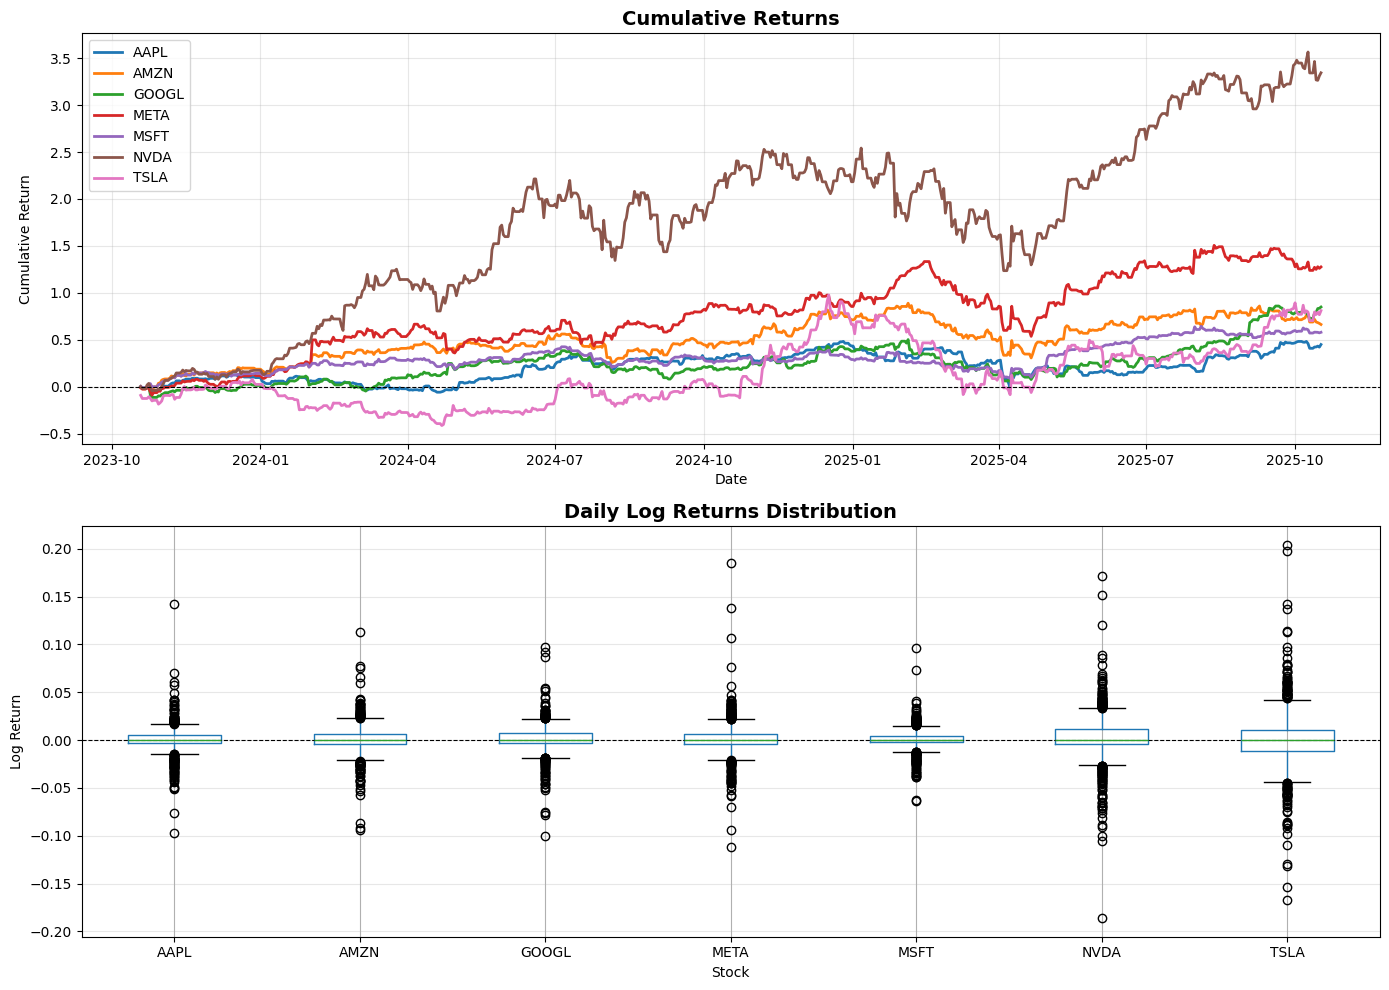

In [7]:
# Plot cumul returns
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

cum_returns = np.exp(returns.cumsum()) - 1

for col in cum_returns.columns:
    ax1.plot(cum_returns.index, cum_returns[col], label=col, linewidth=2)

ax1.set_title('Cumulative Returns', fontsize=14, fontweight='bold')
ax1.set_xlabel('Date')
ax1.set_ylabel('Cumulative Return')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

# Box plot returns
returns.dropna().boxplot(ax=ax2)
ax2.set_title('Daily Log Returns Distribution', fontsize=14, fontweight='bold')
ax2.set_xlabel('Stock')
ax2.set_ylabel('Log Return')
ax2.grid(True, alpha=0.3, axis='y')
ax2.axhline(y=0, color='black', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()


## Univariate analysis

In [8]:
from scipy import stats
from statsmodels.tsa.stattools import adfuller, acf
from statsmodels.stats.diagnostic import acorr_ljungbox

# Test for each stock
for ticker in returns.columns:
    print(f"\n{'='*60}")
    print(f"UNIVARIATE ANALYSIS: {ticker}")
    print(f"{'='*60}")
    
    ret = returns[ticker].dropna()
    
    # 1. Normality Tests
    print("\n--- NORMALITY ---")
    
    # Jarque-Bera test (if pval < 0.05 data is not normal)
    jb_stat, jb_p = stats.jarque_bera(ret)
    print(f"Jarque-Bera: stat={jb_stat:.4f}, p-value={jb_p:.4e} {'(not normal)' if jb_p < 0.05 else '(normal)'}")
    
    # Distribution characteristics
    print(f"\nSkewness: {stats.skew(ret):.4f} (normal=0)")
    print(f"Excess kurtosis: {stats.kurtosis(ret):.4f} (normal=0)")
    
    # 2. Stationarity
    print("\n--- STATIONARITY TEST (ADF) ---")

    # Augmented Dickey Fuller (if pval < 0.05 series is stationary)
    adf_result = adfuller(ret, autolag='AIC')
    print(f"ADF p-value: {adf_result[1]:.4f} {'(stationary)' if adf_result[1] < 0.05 else '(non-stationary)'}")

    # 3. Autocorrelation
    print("\n--- AUTOCORRELATION ---")
    lags = [1, 5, 10, 20, 30]

    # Autocorrel values
    acf_values = acf(ret, nlags=max(lags), fft=False)
    print(f"ACF values:")
    for lag in lags:
        print(f"  Lag {lag}: {acf_values[lag]:.4f}")    
        
    # Ljung-Box test (if pval < 0.05 autocorrel is statistically significant)
    lb_result = acorr_ljungbox(ret, lags=lags, return_df=True)
    print("\nLjung-Box test:")
    lb_result.index.name = 'lag'
    print(lb_result)



UNIVARIATE ANALYSIS: AAPL

--- NORMALITY ---
Jarque-Bera: stat=10001.8480, p-value=0.0000e+00 (not normal)

Skewness: 0.7638 (normal=0)
Excess kurtosis: 18.0692 (normal=0)

--- STATIONARITY TEST (ADF) ---
ADF p-value: 0.0000 (stationary)

--- AUTOCORRELATION ---
ACF values:
  Lag 1: 0.0279
  Lag 5: -0.0296
  Lag 10: -0.0534
  Lag 20: -0.0263
  Lag 30: -0.0587

Ljung-Box test:
       lb_stat  lb_pvalue
lag                      
1     0.569701   0.450378
5     3.759895   0.584476
10   17.082807   0.072552
20   23.760074   0.253030
30   35.758067   0.216105

UNIVARIATE ANALYSIS: AMZN

--- NORMALITY ---
Jarque-Bera: stat=2480.3341, p-value=0.0000e+00 (not normal)

Skewness: -0.0186 (normal=0)
Excess kurtosis: 9.0302 (normal=0)

--- STATIONARITY TEST (ADF) ---
ADF p-value: 0.0000 (stationary)

--- AUTOCORRELATION ---
ACF values:
  Lag 1: -0.0478
  Lag 5: -0.0069
  Lag 10: -0.0103
  Lag 20: 0.0257
  Lag 30: 0.0032

Ljung-Box test:
       lb_stat  lb_pvalue
lag                      
1     1.

## Signal quality

In [9]:
target = 'AAPL'
target_fwd = returns[target].shift(-1)  # Next period AAPL return

print(f"{'='*60}")
print(f"INFORMATION COEFFICIENT ANALYSIS")
print(f"{'='*60}")
print("\nSignal correl to next period target return:")

ic_results = []

for ticker in returns.columns:
    signal = returns[ticker]
    
    # Align signal and target (drop NaN)
    valid_idx = signal.notna() & target_fwd.notna()
    signal_clean = signal[valid_idx]
    target_clean = target_fwd[valid_idx]
    
    # Calculate IC (Pearson correlation)
    ic = np.corrcoef(signal_clean, target_clean)[0, 1]
    print(f"{ticker}: {ic:.4f}")


INFORMATION COEFFICIENT ANALYSIS

Signal correl to next period target return:
AAPL: 0.0279
AMZN: -0.0215
GOOGL: -0.0082
META: -0.0330
MSFT: -0.0754
NVDA: -0.0566
TSLA: -0.0595


## Multivariate analysis

CORRELATION MATRIX



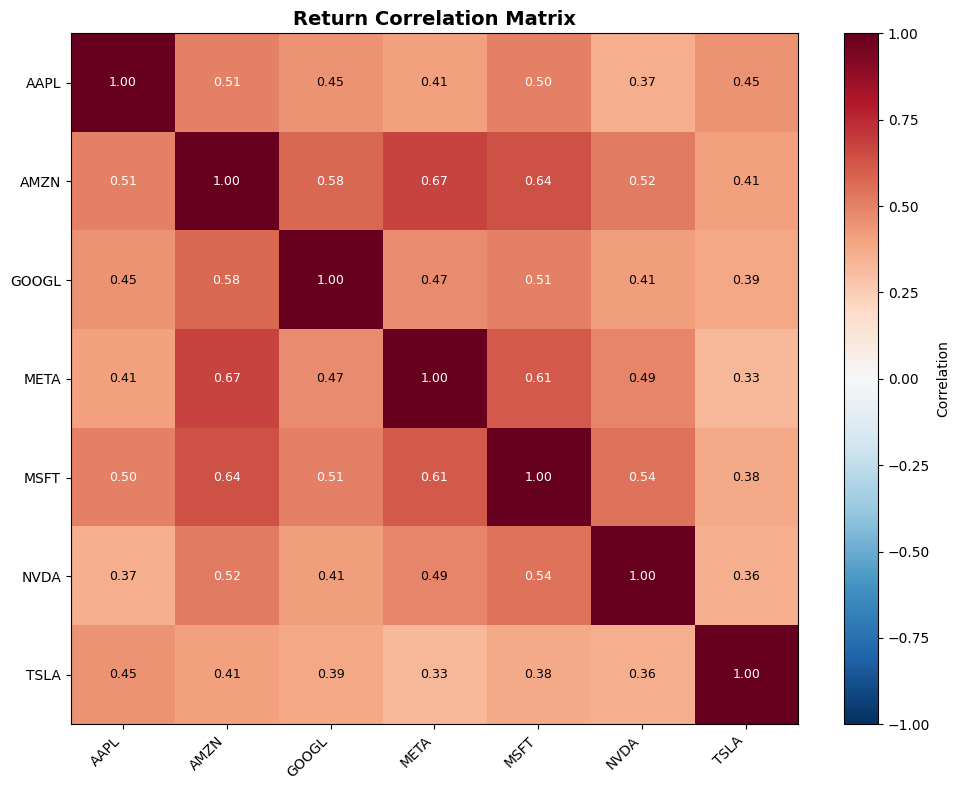


COINTEGRATION ANALYSIS (Engle-Granger)



,Stock1,Stock2,Cointegration Score,P-value,Cointegrated (p<0.05)
0,AMZN,TSLA,-3.226575,0.065595,No
1,AMZN,META,-3.218008,0.066968,No
2,META,NVDA,-3.062236,0.096142,No
3,AMZN,NVDA,-2.968171,0.117966,No
4,AAPL,TSLA,-2.773174,0.174370,No
5,META,TSLA,-2.465822,0.294347,No
6,AAPL,GOOGL,-2.459296,0.297309,No
7,MSFT,TSLA,-2.346271,0.350705,No
8,NVDA,TSLA,-2.345198,0.351229,No
9,MSFT,NVDA,-2.229983,0.408960,No



PRINCIPAL COMPONENT ANALYSIS

Variance explained by each component:
PC1: 55.49% (cumulative: 55.49%)
PC2: 11.33% (cumulative: 66.82%)
PC3: 8.71% (cumulative: 75.54%)
PC4: 7.68% (cumulative: 83.22%)
PC5: 7.19% (cumulative: 90.41%)
PC6: 5.26% (cumulative: 95.67%)
PC7: 4.33% (cumulative: 100.00%)


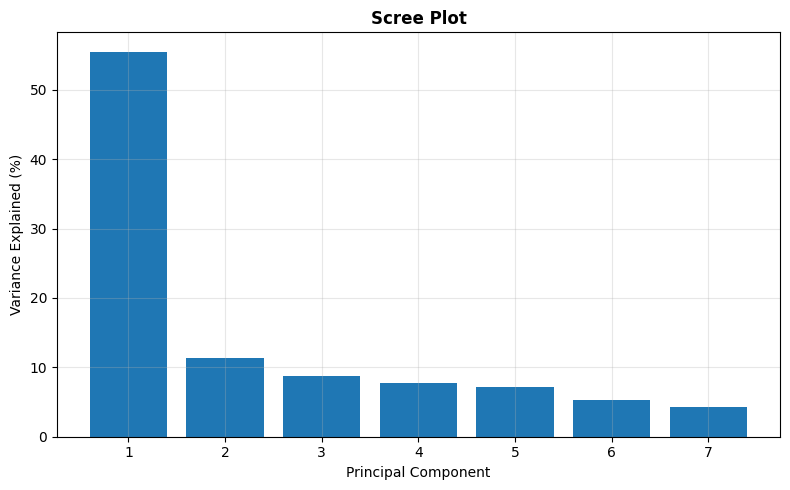


PC1 and PC2 loadings (factor weights):


,PC1,PC2
AAPL,0.354374,0.437952
AMZN,0.428859,-0.184878
GOOGL,0.371094,0.055435
META,0.395071,-0.383156
MSFT,0.414203,-0.211091
NVDA,0.358422,-0.231941
TSLA,0.310929,0.725107


In [10]:
from sklearn.decomposition import PCA
from statsmodels.tsa.stattools import coint

# 1. Correlation Matrix
print(f"{'='*60}")
print("CORRELATION MATRIX")
print(f"{'='*60}\n")

corr_matrix = returns.corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
plt.imshow(corr_matrix, cmap='RdBu_r', vmin=-1, vmax=1, aspect='auto')
plt.colorbar(label='Correlation')
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=45, ha='right')
plt.yticks(range(len(corr_matrix.columns)), corr_matrix.columns)
plt.title('Return Correlation Matrix', fontsize=14, fontweight='bold')

# Add correlation values as text
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        plt.text(j, i, f'{corr_matrix.iloc[i, j]:.2f}',
                ha='center', va='center',
                color='white' if abs(corr_matrix.iloc[i, j]) > 0.5 else 'black',
                fontsize=9)

plt.tight_layout()
plt.show()

# 2. Cointegration Testing (for pairs trading)
print(f"\n{'='*60}")
print("COINTEGRATION ANALYSIS (Engle-Granger)")
print(f"{'='*60}\n")

# Use price data (not returns) for cointegration
data_clean = data.dropna()

# Test all pairs
coint_results = []
for i, stock1 in enumerate(data_clean.columns):
    for stock2 in data_clean.columns[i+1:]:
        # Engle-Granger cointegration test
        score, pvalue, _ = coint(data_clean[stock1], data_clean[stock2])
        coint_results.append({
            'Stock1': stock1,
            'Stock2': stock2,
            'Cointegration Score': score,
            'P-value': pvalue,
            'Cointegrated (p<0.05)': 'Yes' if pvalue < 0.05 else 'No'
        })

coint_df = pd.DataFrame(coint_results)
coint_df = coint_df.sort_values('P-value').reset_index(drop=True)

# print("Pairs ranked by cointegration strength:")
display(coint_df)

# 3. PCA
print(f"\n{'='*60}")
print("PRINCIPAL COMPONENT ANALYSIS")
print(f"{'='*60}\n")

# Use returns for PCA
returns_clean = returns.dropna()

# Standardize returns (mean=0, std=1)
returns_scaled = (returns_clean - returns_clean.mean()) / returns_clean.std()

# Fit PCA
pca = PCA()
pca.fit(returns_scaled)

# Variance explained
explained_var = pca.explained_variance_ratio_
cumulative_var = np.cumsum(explained_var)

print("Variance explained by each component:")
for i, (var, cum_var) in enumerate(zip(explained_var, cumulative_var)):
    print(f"PC{i+1}: {var*100:.2f}% (cumulative: {cum_var*100:.2f}%)")

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(explained_var)+1), explained_var * 100)
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.title('Scree Plot', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Component loadings
print("\nPC1 and PC2 loadings (factor weights):")
loadings_df = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=returns_clean.columns
)
display(loadings_df)


## Predictive analysis

In [11]:
# Mean Reversion Analysis - AR(1) Model & Half-Life
print(f"{'='*60}")
print("MEAN REVERSION: AR(1) MODEL & HALF-LIFE")
print(f"{'='*60}\n")

print("Fitting AR(1) model: ret[t] = alpha + beta * ret[t-1] + epsilon")
print("Half-life = -log(2) / log(beta)\n")

for ticker in returns.columns:
    print(f"\n{ticker}:")
    print("-" * 40)
    
    ret = returns[ticker].dropna()
    
    # Fit AR(1): ret[t] = alpha + beta * ret[t-1] + epsilon
    ret_lag = ret.shift(1).dropna()
    ret_current = ret[ret_lag.index]
    
    # OLS regression
    X = sm.add_constant(ret_lag)
    model = sm.OLS(ret_current, X).fit()
    
    alpha = model.params.iloc[0]
    beta = model.params.iloc[1]
    r_squared = model.rsquared
    
    print(f"  Alpha (constant): {alpha:.6f}")
    print(f"  Beta (AR coef):   {beta:.4f}")
    print(f"  R-squared:        {r_squared:.4f}")
    
    # Half-life calculation
    if abs(beta) < 1 and beta > 0:
        half_life = -np.log(2) / np.log(beta)
        print(f"  Half-life:        {half_life:.2f} days")
        print(f"  Interpretation:   Mean reversion in ~{half_life:.1f} days")
    elif beta < 0:
        print(f"  Half-life:        N/A (negative beta - oscillating)")
    else:
        print(f"  Half-life:        ∞ (no mean reversion)")


MEAN REVERSION: AR(1) MODEL & HALF-LIFE

Fitting AR(1) model: ret[t] = alpha + beta * ret[t-1] + epsilon
Half-life = -log(2) / log(beta)


AAPL:
----------------------------------------
  Alpha (constant): 0.000498
  Beta (AR coef):   0.0279
  R-squared:        0.0008
  Half-life:        0.19 days
  Interpretation:   Mean reversion in ~0.2 days

AMZN:
----------------------------------------
  Alpha (constant): 0.000728
  Beta (AR coef):   -0.0478
  R-squared:        0.0023
  Half-life:        N/A (negative beta - oscillating)

GOOGL:
----------------------------------------
  Alpha (constant): 0.000836
  Beta (AR coef):   0.0103
  R-squared:        0.0001
  Half-life:        0.15 days
  Interpretation:   Mean reversion in ~0.2 days

META:
----------------------------------------
  Alpha (constant): 0.001187
  Beta (AR coef):   -0.0366
  R-squared:        0.0013
  Half-life:        N/A (negative beta - oscillating)

MSFT:
----------------------------------------
  Alpha (constant): 0.0

## Feature selection

In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

# Feature Selection with Lasso
print(f"{'='*60}")
print("LASSO FEATURE SELECTION")
print(f"{'='*60}\n")

# Prepare data: Use all stock returns to predict next-day AAPL return
target = 'AAPL'
y = returns[target].shift(-1).dropna()  # Next day AAPL return

# Features: all stock returns (current day)
X = returns.loc[y.index]

# Drop any remaining NaN
valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target: Next-day {target} return\n")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Fit Lasso with cross-validation to select optimal alpha
print("Fitting LassoCV to find optimal regularization...")
lasso_cv = LassoCV(cv=5, random_state=42, max_iter=10000, alphas=np.logspace(-6, -1, 100))
lasso_cv.fit(X_scaled, y)

print(f"Optimal alpha (CV): {lasso_cv.alpha_:.6f}")
print(f"R-squared (CV): {lasso_cv.score(X_scaled, y):.4f}\n")

# If no features selected, use smaller alpha to force some selection
if (lasso_cv.coef_ == 0).all():
    print("Note: All coefficients are zero with CV alpha. Using smaller alpha...\n")
    from sklearn.linear_model import Lasso
    lasso_cv = Lasso(alpha=1e-6, random_state=42, max_iter=10000)
    lasso_cv.fit(X_scaled, y)
    print(f"Using alpha: {1e-6:.6f}")
    print(f"R-squared: {lasso_cv.score(X_scaled, y):.4f}\n")

# Get coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_cv.coef_
})
coefficients['Abs_Coef'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coef', ascending=False)

print("Feature importance (Lasso coefficients):")
display(coefficients)

# Selected features (non-zero coefficients)
selected_features = coefficients[coefficients['Coefficient'] != 0]['Feature'].tolist()

print(f"\n{'='*60}")
print(f"SELECTED FEATURES: {len(selected_features)}/{len(X.columns)}")
print(f"{'='*60}")
if selected_features:
    for feat in selected_features:
        coef = coefficients[coefficients['Feature'] == feat]['Coefficient'].values[0]
        print(f"  {feat}: {coef:.6f}")


LASSO FEATURE SELECTION

Dataset shape: (729, 7)
Features: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Target: Next-day AAPL return

Fitting LassoCV to find optimal regularization...
Optimal alpha (CV): 0.100000
R-squared (CV): 0.0000

Note: All coefficients are zero with CV alpha. Using smaller alpha...

Using alpha: 0.000001
R-squared: 0.0168

Feature importance (Lasso coefficients):


,Feature,Coefficient,Abs_Coef
4,MSFT,-0.001680,0.001680
0,AAPL,0.001470,0.001470
6,TSLA,-0.001058,0.001058
5,NVDA,-0.000484,0.000484
1,AMZN,0.000427,0.000427
2,GOOGL,0.000402,0.000402
3,META,0.000064,0.000064



SELECTED FEATURES: 7/7
  MSFT: -0.001680
  AAPL: 0.001470
  TSLA: -0.001058
  NVDA: -0.000484
  AMZN: 0.000427
  GOOGL: 0.000402
  META: 0.000064


## Prediction: XGBoost

XGBOOST: PREDICT NEXT-DAY AAPL RETURN

Dataset shape: (729, 7)
Features: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Target: Next-day AAPL return

Train size: 583
Test size: 146

Training XGBoost...

RESULTS
Train R²:    0.5229
Test R²:     -0.0352
Train RMSE:  0.010408
Test RMSE:   0.012083
Train MAE:   0.006444
Test MAE:    0.007814

Feature Importance:


,Feature,Importance
1,AMZN,0.190132
6,TSLA,0.179103
0,AAPL,0.173458
3,META,0.130174
2,GOOGL,0.122197
4,MSFT,0.110549
5,NVDA,0.094388


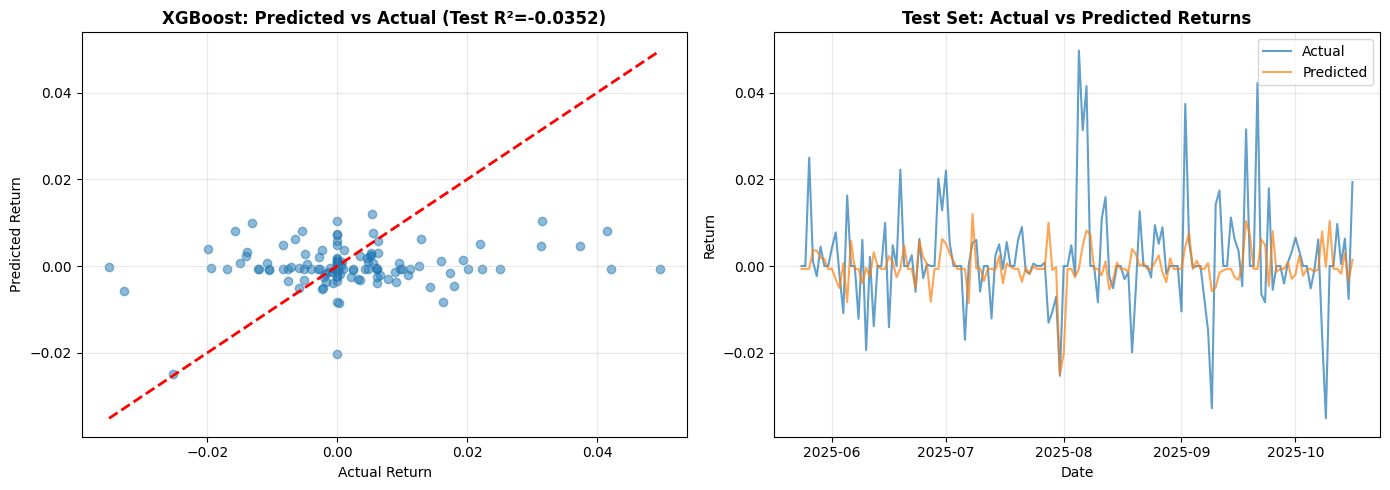

In [14]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# XGBoost Prediction
print(f"{'='*60}")
print("XGBOOST: PREDICT NEXT-DAY AAPL RETURN")
print(f"{'='*60}\n")

# Prepare data
target = 'AAPL'
y = returns[target].shift(-1).dropna()  # Next day AAPL return
X = returns.loc[y.index]

# Drop NaN
valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target: Next-day {target} return\n")

# Train/test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}\n")

# Train XGBoost
print("Training XGBoost...")
model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    objective='reg:squarederror'
)
model.fit(X_train, y_train)

# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Evaluate
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"Train R²:    {train_r2:.4f}")
print(f"Test R²:     {test_r2:.4f}")
print(f"Train RMSE:  {train_rmse:.6f}")
print(f"Test RMSE:   {test_rmse:.6f}")
print(f"Train MAE:   {train_mae:.6f}")
print(f"Test MAE:    {test_mae:.6f}")

# Feature importance
print(f"\nFeature Importance:")
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values('Importance', ascending=False)
display(feature_imp)

# Plot predictions vs actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_test_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Return')
ax1.set_ylabel('Predicted Return')
ax1.set_title(f'XGBoost: Predicted vs Actual (Test R²={test_r2:.4f})', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
ax2.plot(y_test.index, y_test_pred, label='Predicted', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Return')
ax2.set_title('Test Set: Actual vs Predicted Returns', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Prediction: LSTM

LSTM (PYTORCH): PREDICT NEXT-DAY AAPL RETURN

Dataset shape: (729, 7)
Features: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']
Target: Next-day AAPL return

Train size: 583
Test size: 146

Training LSTM...
Model: 7 features → LSTM(64, 2 layers) → FC(1)

Training LSTM...
Model: 7 features → LSTM(64, 2 layers) → FC(1)

Epoch [10/50], Loss: 0.981136
Epoch [10/50], Loss: 0.981136
Epoch [20/50], Loss: 0.938568
Epoch [20/50], Loss: 0.938568
Epoch [30/50], Loss: 0.965835
Epoch [30/50], Loss: 0.965835
Epoch [40/50], Loss: 1.025992
Epoch [40/50], Loss: 1.025992
Epoch [50/50], Loss: 0.900151

RESULTS
Train R²:    0.1005
Test R²:     0.0001
Train RMSE:  0.014292
Test RMSE:   0.011875
Train MAE:   0.008122
Test MAE:    0.007480
Epoch [50/50], Loss: 0.900151

RESULTS
Train R²:    0.1005
Test R²:     0.0001
Train RMSE:  0.014292
Test RMSE:   0.011875
Train MAE:   0.008122
Test MAE:    0.007480


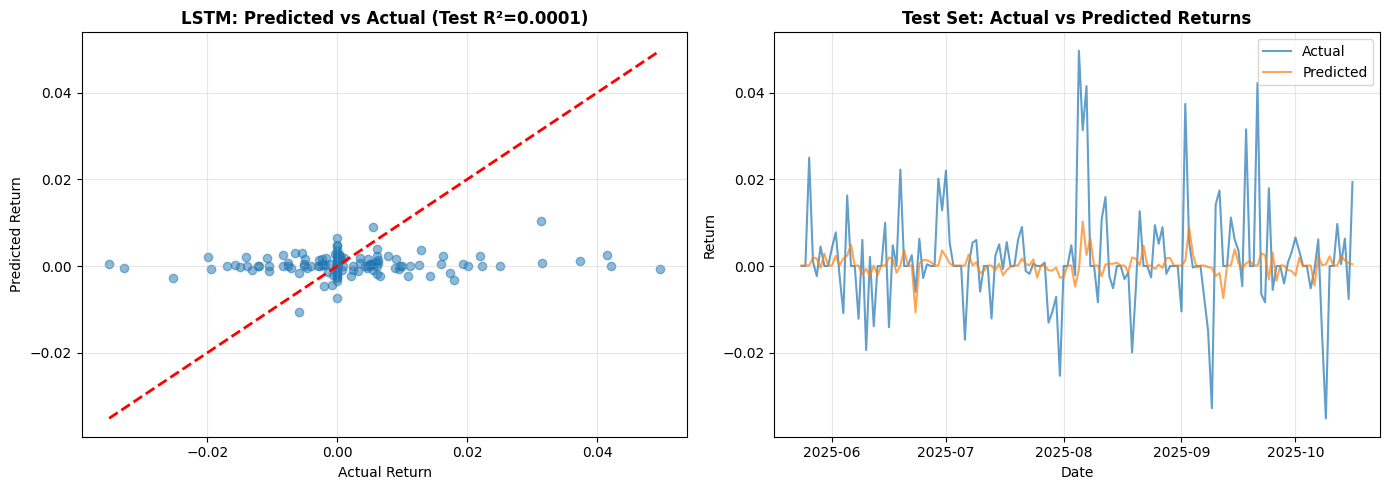

In [15]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# LSTM Prediction
print(f"{'='*60}")
print("LSTM (PYTORCH): PREDICT NEXT-DAY AAPL RETURN")
print(f"{'='*60}\n")

# Prepare data (reuse from XGBoost)
target = 'AAPL'
y = returns[target].shift(-1).dropna()
X = returns.loc[y.index]

valid_idx = X.notna().all(axis=1) & y.notna()
X = X[valid_idx]
y = y[valid_idx]

print(f"Dataset shape: {X.shape}")
print(f"Features: {list(X.columns)}")
print(f"Target: Next-day {target} return\n")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Standardize
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled).unsqueeze(1)  # (batch, seq_len=1, features)
X_test_tensor = torch.FloatTensor(X_test_scaled).unsqueeze(1)
y_train_tensor = torch.FloatTensor(y_train_scaled)
y_test_tensor = torch.FloatTensor(y_test_scaled)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

print(f"Train size: {len(X_train)}")
print(f"Test size: {len(X_test)}\n")

# Define LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])  # Take last time step
        return out.squeeze()

# Initialize model
input_size = X_train.shape[1]
model_lstm = LSTMModel(input_size=input_size, hidden_size=64, num_layers=2, dropout=0.2)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_lstm.parameters(), lr=0.001)

print("Training LSTM...")
print(f"Model: {input_size} features → LSTM(64, 2 layers) → FC(1)\n")

# Training loop
num_epochs = 50
model_lstm.train()
for epoch in range(num_epochs):
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_lstm(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    if (epoch + 1) % 10 == 0:
        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

# Evaluation
model_lstm.eval()
with torch.no_grad():
    y_train_pred_scaled = model_lstm(X_train_tensor).numpy()
    y_test_pred_scaled = model_lstm(X_test_tensor).numpy()

# Inverse transform predictions
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# Metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\n{'='*60}")
print("RESULTS")
print(f"{'='*60}")
print(f"Train R²:    {train_r2:.4f}")
print(f"Test R²:     {test_r2:.4f}")
print(f"Train RMSE:  {train_rmse:.6f}")
print(f"Test RMSE:   {test_rmse:.6f}")
print(f"Train MAE:   {train_mae:.6f}")
print(f"Test MAE:    {test_mae:.6f}")

# Plot predictions vs actual
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.scatter(y_test, y_test_pred, alpha=0.5)
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Return')
ax1.set_ylabel('Predicted Return')
ax1.set_title(f'LSTM: Predicted vs Actual (Test R²={test_r2:.4f})', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(y_test.index, y_test.values, label='Actual', alpha=0.7)
ax2.plot(y_test.index, y_test_pred, label='Predicted', alpha=0.7)
ax2.set_xlabel('Date')
ax2.set_ylabel('Return')
ax2.set_title('Test Set: Actual vs Predicted Returns', fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
